In [ ]:
# To load numpy
import numpy as np
import pandas as pd

# To load datasets
from sklearn import datasets
# To import the classifier
from sklearn.neural_network import MLPClassifier
# To measure accuracy
from sklearn import metrics
from sklearn import model_selection
# To import the scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import accuracy_score

# To support plots
import matplotlib.pyplot as plt

seed = 520
np.set_printoptions(precision=3)

In [ ]:
class DummyScaler:
    def fit(self, data):
        pass
    def transform(self, data):
        return data
def ROCcurve_old(evaluatetype, y, y_prob):
    print('ROC curve')
        # ROC curve code here is for 2 classes only
    if len(np.unique(y)) == 4:
        plt.figure()
        fpr, tpr, threshold = metrics.roc_curve(y, y_prob)
        roc_auc = metrics.auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic (' + evaluatetype + ')')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

def evaluate_model(evaluatetype, y, y_hat):
    print('Model evaluation (' + evaluatetype + ')')
    print('Accuracy:')
    print(metrics.accuracy_score(y, y_hat))
    print('Classification report:')
    #encoder.classes_=['A','F','G','H']
    #pretty = list(encoder.classes_)            # ['A','F','G','H']

    print(metrics.classification_report(y, y_hat, target_names=['A','F','G','H'] ))
    print('Confusion matrix (' + evaluatetype + ')')
    #df = pd.DataFrame({'y_Actual': y, 'y_Predicted': y_hat})
    #confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], dropna=False)
    #label_names=['A','F','G','H']
    label_names = sorted(np.unique(y))

    cm = metrics.confusion_matrix(y, y_hat, labels=label_names)
    df_cm = pd.DataFrame(cm,
                     index=pd.Index(label_names, name="Actual"),
                     columns=pd.Index(label_names, name="Predicted"))
    print(df_cm)



def ROCcurve(evaluatetype, y, y_prob, class_names=None):
    """
    y       : (n_samples,)  -> true labels (ints 0..K-1 or strings)
    y_prob  : (n_samples, n_classes) for multiclass; 1D or (n_samples,2) for binary
    class_names : optional list of names in the SAME order as y_prob columns (multiclass)
    """
    print('ROC curve')
    y = np.asarray(y)
    n_unique = len(np.unique(y))

    # --- Binary special case ---
    if n_unique == 2:
        # Accept 1D scores or 2D probs
        if y_prob.ndim == 2:
            if y_prob.shape[1] != 2:
                raise ValueError(f"Binary ROC expects y_prob with 2 columns; got {y_prob.shape}.")
            scores = y_prob[:, 1]
        else:
            scores = y_prob  # 1D
        pos_label = sorted(np.unique(y))[1]
        fpr, tpr, _ = roc_curve(y, scores, pos_label=pos_label)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                        estimator_name=f"{evaluatetype} (binary)").plot()
        plt.title(f"ROC ({evaluatetype}) | AUC={roc_auc:.3f}")
        plt.grid(True); plt.show()
        return {"micro_auc": roc_auc, "macro_auc": roc_auc, "per_class_auc": {str(pos_label): roc_auc}}

    # --- Multiclass (OVR) ---
    if y_prob.ndim != 2:
        raise ValueError(f"Multiclass ROC needs y_prob 2D; got {y_prob.shape}.")
    n_classes = n_unique
    if y_prob.shape[1] != n_classes:
        raise ValueError(f"y_prob has {y_prob.shape[1]} columns but y has {n_classes} classes. "
                         f"Check how you built y_prob (don’t slice like [:,1]).")

    # Decide column order for binarization
    classes_sorted = np.sort(np.unique(y))  # assumed same order as y_prob columns
    disp_names = list(classes_sorted) if class_names is None else list(class_names)

    # Binarize y in that order
    Y_bin = label_binarize(y, classes=classes_sorted)

    # Compute per-class ROC
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        yi = Y_bin[:, i]           # binary true for class i
        si = y_prob[:, i]          # scores/prob of class i
        fpr[i], tpr[i], _ = roc_curve(yi, si)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro / macro
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    roc_auc["macro"] = float(np.mean([roc_auc[i] for i in range(n_classes)]))

    # Plot
    plt.figure()
    ax = plt.gca()
    for i in range(n_classes):
        label = f"{disp_names[i]} (AUC={roc_auc[i]:.3f})"
        RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i],
                        estimator_name=label).plot(ax=ax)
    RocCurveDisplay(fpr=fpr["micro"], tpr=tpr["micro"], roc_auc=roc_auc["micro"],
                    estimator_name=f"micro (AUC={roc_auc['micro']:.3f})").plot(ax=ax)
    plt.title(f"ROC (OVR) — {evaluatetype} | macro AUC={roc_auc['macro']:.3f}")
    plt.grid(True); plt.show()

    return {
        "per_class_auc": {str(disp_names[i]): roc_auc[i] for i in range(n_classes)},
        "macro_auc": roc_auc["macro"],
        "micro_auc": roc_auc["micro"]
    }


In [ ]:
def create_data():

    #FILENAME = r"c:\Users\runger\Desktop\Courses\ClassFall2020\Data\spine.csv"

    url = "https://drive.google.com/uc?id=1IN3pO0JYQoJoOQ3HWH0L4ALy01o_yxOd"
    # Load dataset
    df = pd.read_csv(url,header=0)
    # Actual last column name
    target_col = "Class: A, B, C, D, E, F, G, H, I, W, X, Y"

    # Keep only classes A, F, G, H
    df = df[df[target_col].isin(["A", "F", "G", "H"])]
    # df = pd.read_excel(FILENAME, header=0)
    #df = pd.read_csv(FILENAME, header=0)
    # change to numpy array to handle cross validation
    X = df.iloc[:,:-1].values
    y = df.iloc[:, -1].values

    print('Features:')
    print('Shape of X \n', X.shape)
    print(X[:20])

    print('Targets:')
    print('Shape of y \n', y.shape)
    print('Classes \n', np.unique(y))

    print('Before transformation:')
    print(y[:20])

    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)

    print('After transformation:')
    print(y[:20])

    return X, y


In [ ]:
print('Load the data')
X, y = create_data()

Load the data
Features:
Shape of X 
 (14427, 10)
[[ 0.266 -0.166  0.321  0.483  0.172  0.273  0.371  0.93   0.251  0.159]
 [ 0.13   0.871 -3.211  0.062  0.262  1.436  1.466  0.636  0.282  0.516]
 [-0.117  0.07   0.068 -0.783  0.262  0.439 -0.082 -0.888 -0.123  0.583]
 [ 0.032  0.298 -3.211 -0.584 -0.721 -0.308  0.711  1.052  0.594 -0.534]
 [ 0.229  0.808 -0.052  0.083  0.262  0.149  0.635  0.051  0.033 -0.087]
 [ 0.118 -0.221 -3.211 -1.623  0.262 -0.35   0.258 -0.386 -0.248 -0.331]
 [ 0.39  -0.221 -3.211 -2.624  0.262 -0.765  0.484 -0.598 -0.372 -0.81 ]
 [ 0.019 -0.04   0.289 -0.043  0.262 -1.014  0.069  0.891  0.095 -0.842]
 [ 0.501  0.141  0.389 -0.637  0.262 -0.682  0.296  0.931  0.501 -0.642]
 [-0.043 -2.395 -3.211 -1.128 -0.721  0.398  0.258 -1.167 -0.061  0.346]
 [ 0.044 -0.173  0.285 -0.775  0.172 -0.391  0.333 -1.808 -0.996 -0.411]
 [ 0.155  0.337  0.068  0.022  0.262  0.024  0.031  0.079  0.314  0.126]
 [-0.005 -0.323  0.1   -0.519  0.262 -0.308  0.069 -0.574  0.282 -0.183]
 [

In [ ]:
base_model = MLPClassifier(hidden_layer_sizes=(100,50), random_state=seed, max_iter = 5000, tol=1e-10)
np.random.seed(seed)
n_classes = len(np.unique(y))
y_prob = np.zeros((len(y), n_classes))
y_hat = np.empty(len(y), dtype=y.dtype)


#kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Cross-validation
for train, test in kfold.split(X, y):
    model = clone(base_model)
    # Train classifier on training data, predict test data

    # Scaling train and test data
    # Train scaler on training set only
    #scaler.fit(X_train[train])
    #X_train = scaler.transform(X_train[train])
    #X_test = scaler.transform(X_train[test])

    model.fit(X[train], y[train])
    y_hat[test] = model.predict(X[test])
    y_prob[test,:] = model.predict_proba(X[test])

In [ ]:
evaluate_model("CV", y, y_hat)

Model evaluation (CV)
Accuracy:
0.9682539682539683
Classification report:
              precision    recall  f1-score   support

           A       0.97      0.98      0.98      8572
           F       0.97      0.95      0.96      3923
           G       0.95      0.95      0.95       893
           H       0.96      0.95      0.95      1039

    accuracy                           0.97     14427
   macro avg       0.96      0.96      0.96     14427
weighted avg       0.97      0.97      0.97     14427

Confusion matrix (CV)
Predicted     0     1    2    3
Actual                         
0          8408   106   31   27
1           167  3727   14   15
2            27    14  851    1
3            37    15    4  983


ROC curve


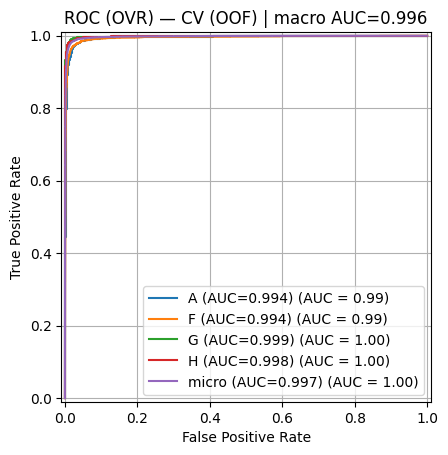

{'per_class_auc': {'A': np.float64(0.9939586635015679),
  'F': np.float64(0.9944748115814347),
  'G': np.float64(0.9987307483735955),
  'H': np.float64(0.9984616968408351)},
 'macro_auc': 0.9964064800743583,
 'micro_auc': np.float64(0.9972521191263464)}

In [ ]:
ROCcurve("CV (OOF)", y, y_prob, class_names=['A','F','G','H'])

In [ ]:
# Define your bigger model
base_model = MLPClassifier(hidden_layer_sizes=(100,50),
                           random_state=seed, max_iter=5000, tol=1e-10)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

train_accs, val_accs = [], []

fold = 1
for train_idx, val_idx in skf.split(X, y):
    model = clone(base_model)
    model.fit(X[train_idx], y[train_idx])

    # Accuracy on training fold
    y_train_pred = model.predict(X[train_idx])
    train_acc = accuracy_score(y[train_idx], y_train_pred)

    # Accuracy on validation fold
    y_val_pred = model.predict(X[val_idx])
    val_acc = accuracy_score(y[val_idx], y_val_pred)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Fold {fold}: Train acc = {train_acc:.4f}, Validation acc = {val_acc:.4f}")
    fold += 1

print("\nAverage train accuracy:", np.mean(train_accs))
print("Average validation accuracy:", np.mean(val_accs))
print("Generalization error (est):", 1 - np.mean(val_accs))


Fold 1: Train acc = 0.9997, Validation acc = 0.9744
Fold 2: Train acc = 0.9987, Validation acc = 0.9768
Fold 3: Train acc = 0.9959, Validation acc = 0.9640
Fold 4: Train acc = 0.9883, Validation acc = 0.9657
Fold 5: Train acc = 0.9900, Validation acc = 0.9605

Average train accuracy: 0.9945243173400714
Average validation accuracy: 0.9682529536602328
Generalization error (est): 0.031747046339767215
